## Imports

In [10]:
!pip install PyWavelets

import re
import contextlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
from scipy import signal, stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D, Dropout


## Data Cleaning and Preprocessing

In [11]:
def load_eeg_data(filepath: str) -> tuple[pd.DataFrame, float]:
    """Load EEG data with automatic sample rate detection.

    Args:
        filepath: Path to CSV file containing EEG data

    Returns:
        Tuple containing:
        - DataFrame with EEG channels and sample index
        - Sampling frequency in Hz
    """
    # Helper function to find sample rate in a row
    def find_sample_rate(row: str) -> float | None:
        for value in row.split(';'):
            with contextlib.suppress(ValueError, TypeError):
                if 100 <= (sf := float(value)) <= 1000:
                    return sf
        return None

    # Read first two lines
    with open(filepath) as f:
        lines = [f.readline().strip(), f.readline().strip()]

    # Detect sample rate and header presence
    sfreq = find_sample_rate(lines[0]) or find_sample_rate(lines[1]) or 250.0
    skiprows = 2 if sfreq in (find_sample_rate(lines[0]), find_sample_rate(lines[1])) else 0

    # Load data with pandas
    df = pd.read_csv(
        filepath,
        sep=';',
        skiprows=skiprows,
        usecols=range(11),
        names=['SampleIndex', 'FP1', 'FP2', 'Channel3', 'Channel4', 'Channel5',
               'Channel6', 'Channel7', 'Channel8', 'Channel9', 'Channel10'],
        dtype=np.float32,
        engine='c'
    ).reset_index(drop=True)

    # Validate sample rate
    if not 100 <= sfreq <= 1000:
        raise ValueError(f"Invalid sample rate {sfreq}Hz detected")

    return df, float(sfreq)

def clean_eeg_data(df, sfreq):
    """Main cleaning pipeline"""
    # 1. Remove constant invalid values (-187500)
    eeg_channels = ['FP1', 'FP2', 'Channel3', 'Channel4', 'Channel5']
    df[eeg_channels] = df[eeg_channels].replace(-187500.02, np.nan)

    # 2. Handle missing values
    df = df.ffill().bfill()

    # 3. Remove non-EEG columns (using ACTUAL existing columns)
    df = df[['SampleIndex'] + eeg_channels]  # Now matches loaded columns

    # 4. Convert to μV to Volts
    df[eeg_channels] /= 1e6  # Convert from μV to V

    # 5. Outlier removal using Hampel filter
    for ch in eeg_channels:
        median = df[ch].rolling(window=100, center=True).median()
        mad = np.abs(df[ch] - median).rolling(window=100, center=True).median()
        df[ch] = np.where(np.abs(df[ch] - median) > 3*mad, median, df[ch])

    # 6. Bandpass filtering (1-40 Hz) with Nyquist check
    nyquist = 0.5 * sfreq
    low = 1.0
    high = min(40.0, nyquist * 0.95)  # Ensure we stay below Nyquist

    # Validate frequency range
    if low >= high:
        raise ValueError(f"Invalid filter range: low={low}Hz, high={high}Hz (Nyquist={nyquist}Hz)")

    sos = signal.butter(2, [low, high], btype='bandpass', fs=sfreq, output='sos')
    for ch in eeg_channels:
        df[ch] = signal.sosfiltfilt(sos, df[ch])


    # 7. Notch filter (50 Hz)
    b, a = signal.iirnotch(50, 30, fs=sfreq)
    for ch in eeg_channels:
        df[ch] = signal.filtfilt(b, a, df[ch])

    return df

# Denoise Method
def wavelet_denoise(signal_data, wavelet='db4', level=3):
    """Improved wavelet denoising with auto-padding"""
    # Calculate required length (next multiple of 2^level)
    required_length = ((len(signal_data) + (2 ** level - 1)) // (2 ** level)) * (2 ** level)
    padded_signal = np.pad(signal_data, (0, required_length - len(signal_data)),
                         mode='edge')

    # Now calculate max_level based on the padded signal length
    max_level = pywt.swt_max_level(len(padded_signal))
    adjusted_level = min(level, max_level)

    if adjusted_level < 1:
        raise ValueError(f"Cannot perform SWT with level {adjusted_level}. Need at least level 1.")

    # Perform SWT with adjusted level
    coeffs = pywt.swt(padded_signal, wavelet, level=adjusted_level)

    # Adaptive thresholding
    sigma = np.median(np.abs(coeffs[-1][1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(padded_signal)))

    # Apply threshold to detail coefficients
    denoised_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for c in coeffs[1:]:
        denoised_coeffs.append(pywt.threshold(c, threshold, mode='soft'))

    # Reconstruct signal
    denoised = pywt.iswt(denoised_coeffs, wavelet)
    return denoised[:len(signal_data)]  # Remove padding


In [9]:
# Load data
raw_df, sfreq = load_eeg_data("S00_data.csv")

print(raw_df.iloc[0].to_dict())  # First row of loaded data
print("Sample rate:", sfreq)  # Should show 250 for your data

# Clean data
clean_df = clean_eeg_data(raw_df, sfreq)

# Apply wavelet denoising to kept channel
eeg_channels = ['FP1', 'FP2', 'Channel3', 'Channel4', 'Channel5']

# Apply wavelet denoising
for ch in eeg_channels:
    clean_df[ch] = wavelet_denoise(clean_df[ch].values)

{'SampleIndex': 0.00390625, 'FP1': 8077.9873046875, 'FP2': -8250.5869140625, 'Channel3': -35346.33203125, 'Channel4': -187500.015625, 'Channel5': 187500.0, 'Channel6': 187500.0, 'Channel7': -187500.015625, 'Channel8': 187500.0, 'Channel9': 0.0, 'Channel10': 0.0}
Sample rate: 250.0


In [12]:
# Create a list of file names from S00_data.csv to S15_data.csv
file_list = [f"S{str(i).zfill(2)}_data.csv" for i in range(16)]
all_subjects_df = []

for file in file_list:
    # Load the data and sample frequency for the current file
    raw_df, sfreq = load_eeg_data(file)
    print(f"Processing file: {file}")

    # Clean the loaded data
    clean_df = clean_eeg_data(raw_df, sfreq)

    # List of channels to apply wavelet denoising on
    eeg_channels = ['FP1', 'FP2', 'Channel3', 'Channel4', 'Channel5']
    for ch in eeg_channels:
        clean_df[ch] = wavelet_denoise(clean_df[ch].values)

    # Determine a binary label based on the subject number.
    # For example, label 0 for subjects S00-S07 and label 1 for subjects S08-S15.
    subject_id = int(file[1:3])
    label = 0 if subject_id < 8 else 1

    # Add the label (and optionally the subject id) as new columns
    clean_df['label'] = label
    clean_df['subject'] = file[:3]

    # Append the processed DataFrame to the list
    all_subjects_df.append(clean_df)

# Combine all subject DataFrames into one
combined_df = pd.concat(all_subjects_df, ignore_index=True)

# Preview the combined DataFrame
print(combined_df.head())

Processing file: S00_data.csv
Processing file: S01_data.csv
Processing file: S02_data.csv
Processing file: S03_data.csv
Processing file: S04_data.csv
Processing file: S05_data.csv
Processing file: S06_data.csv
Processing file: S07_data.csv
Processing file: S08_data.csv
Processing file: S09_data.csv
Processing file: S10_data.csv
Processing file: S11_data.csv
Processing file: S12_data.csv
Processing file: S13_data.csv
Processing file: S14_data.csv
Processing file: S15_data.csv
   SampleIndex       FP1       FP2  Channel3      Channel4      Channel5  \
0     0.003906  0.000091  0.000060 -0.000227  1.153851e-17 -4.884712e-28   
1     0.007812  0.000189  0.000119 -0.000181  2.707180e-18 -4.857305e-28   
2     0.011719  0.000269  0.000162 -0.000094  1.694354e-18 -4.797873e-28   
3     0.015625  0.000280  0.000167 -0.000195  3.175886e-18 -4.701248e-28   
4     0.019531  0.000269  0.000164 -0.000443 -1.503280e-19 -4.575562e-28   

   label subject  
0      0     S00  
1      0     S00  
2     

In [14]:
combined_df.head()

,SampleIndex,FP1,FP2,Channel3,Channel4,Channel5,label,subject
0,0.003906,0.000091,0.000060,-0.000227,1.153851e-17,-4.884712e-28,0,S00
1,0.007812,0.000189,0.000119,-0.000181,2.707180e-18,-4.857305e-28,0,S00
2,0.011719,0.000269,0.000162,-0.000094,1.694354e-18,-4.797873e-28,0,S00
3,0.015625,0.000280,0.000167,-0.000195,3.175886e-18,-4.701248e-28,0,S00
4,0.019531,0.000269,0.000164,-0.000443,-1.503280e-19,-4.575562e-28,0,S00


##CNN Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming clean_df contains preprocessed data with 250-sample windows
# and you have labels for each window

# 1. Prepare EEG Data (FP1 and FP2 channels)
def create_segments(df, window_size=250):
    """Convert DataFrame to 3D array of shape (n_samples, window_size, n_channels)"""
    eeg_data = df[['FP1', 'FP2']].values
    n_samples = len(eeg_data) // window_size
    return eeg_data[:n_samples*window_size].reshape(n_samples, window_size, 2)

# Create input segments (X)
X = create_segments(clean_df)  # Shape: (n_samples, 250, 2)

# 2. Prepare Labels (Replace with your actual labels)
# y should be a 1D array where 0 = involuntary blink, 1 = voluntary blink


y = np.random.randint(0, 2, size=X.shape[0])  # REPLACE THIS WITH YOUR LABELS

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Normalize using training data statistics
train_mean = np.mean(X_train, axis=(0, 1))
train_std = np.std(X_train, axis=(0, 1))

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

# 5. One-Hot Encode Labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# 6. Build and Train Model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(250, 2)),
    MaxPooling1D(2),
    Dropout(0.5),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# 7. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 248, 64)             │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 124, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 124, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,498 (994.13 KB)

 Trainable params: 254,498 (994.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.4440 - loss: 0.7254 - val_accuracy: 0.7778 - val_loss: 0.6984
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6506 - loss: 0.6461 - val_accuracy: 1.0000 - val_loss: 0.5770
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6319 - loss: 0.6555 - val_accuracy: 0.7778 - val_loss: 0.6163
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7266 - loss: 0.6221 - val_accuracy: 0.8889 - val_loss: 0.6930
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7344 - loss: 0.5890 - val_accuracy: 0.8889 - val_loss: 0.9401
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7539 - loss: 0.6192 - val_accuracy: 0.8889 - val_loss: 1.0519
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7313 - loss: 0.5749 - val_accuracy: 0.8889 - val_loss: 0.9318
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7266 - loss: 0.5716 - val_accuracy: 0.8889 - val_loss: 0.6123

In [ ]:
# Your X should have this shape:
print(X.shape)  # (number_of_windows, 250, 2)

# Your y should have this shape:
print(y.shape)  # (number_of_windows,)

(102, 250, 2)
(102,)


In [ ]:
def create_sliding_windows(data, labels, window_size=250, sfreq=250):
    """Create sliding windows from continuous data (1s windows at 250Hz)"""
    X = []
    y = []

    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        # Check if window contains a blink label
        if np.any(labels[i:i+window_size] == 1):  # Adjust based on your labeling
            X.append(window)
            y.append(1)  # Voluntary blink
        else:
            X.append(window)
            y.append(0)  # Involuntary

    return np.array(X), np.array(y)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1),
                            np.argmax(y_pred, axis=1),
                            target_names=['Involuntary', 'Voluntary']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
              precision    recall  f1-score   support

 Involuntary       0.43      0.75      0.55         8
   Voluntary       0.71      0.38      0.50        13

    accuracy                           0.52        21
   macro avg       0.57      0.57      0.52        21
weighted avg       0.61      0.52      0.52        21



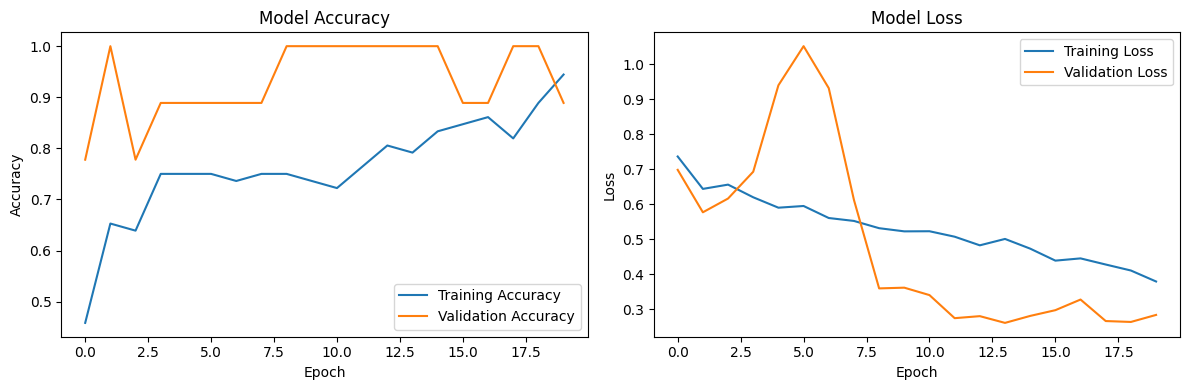

In [ ]:
import matplotlib.pyplot as plt

# After training, plot metrics
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)


##CNN-LSTM Model Blink Prediction

Data shape: (25267, 250, 2)
Class balance: (array([0, 1]), array([24168,  1099]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 246, 32)             │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 123, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 123, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 123, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,633 (147.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.8340 - loss: 0.7687 - precision: 0.1791 - val_accuracy: 0.3373 - val_loss: 0.9153 - val_precision: 0.0573
Epoch 2/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - accuracy: 0.7859 - loss: 0.5360 - precision: 0.1595 - val_accuracy: 0.7992 - val_loss: 0.4089 - val_precision: 0.1701
Epoch 3/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 63s 111ms/step - accuracy: 0.8378 - loss: 0.6248 - precision: 0.1838 - val_accuracy: 0.7859 - val_loss: 0.4887 - val_precision: 0.1624
Epoch 4/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.8397 - loss: 0.5966 - precision: 0.1919 - val_accuracy: 0.7893 - val_loss: 0.3389 - val_precision: 0.1686
Epoch 5/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 86s 117ms/step - accuracy: 0.8285 - loss: 0.4924 - precision: 0.1926 - val_accuracy: 0.8848 - val_loss: 0.3426 - val_precision: 0.2526
Epoch 6/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 81s 116ms/step - accuracy: 0.8478 - loss: 0.6448 - precision: 0.1974 - val_accuracy: 

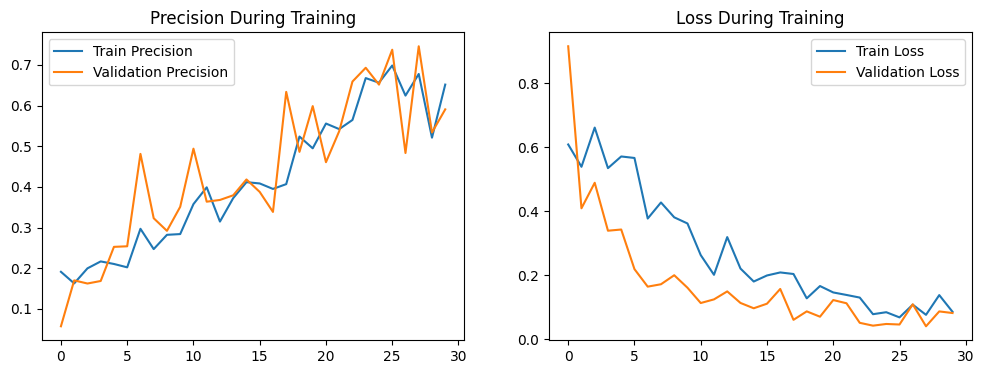


Test Set Performance:
Accuracy: 0.98 | Precision: 0.66

Blink probability in next 200ms: 100.00%
ALERT: Delay camera shutter!


In [ ]:

# FP1 and FP2 are our primary channels for blink detection
eeg_data = clean_df[['FP1', 'FP2']].values

# Create blink event labels (0=no blink, 1=blink)
# You need to replace this with your actual blink labels/event markers!
# This is a placeholder using amplitude thresholding:
detected_events = (np.abs(eeg_data[:,0]) > 0.0002).astype(int)  # Adjust threshold based on your data

# 2. Create Forecasting Windows
def create_forecast_windows(data, labels, input_steps=250, output_steps=50):
    """Create input/output pairs for blink prediction."""
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        # Check if any blink occurs in next 200ms (50 samples @250Hz)
        y.append(1 if np.any(labels[i+input_steps:i+input_steps+output_steps]) else 0)
    return np.array(X), np.array(y)

X, y = create_forecast_windows(eeg_data, detected_events)

print(f"Data shape: {X.shape}")  # Should be (n_windows, 250, 2)
print(f"Class balance: {np.unique(y, return_counts=True)}")

# 3. Train/Test Split & Normalization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize using training data statistics
train_mean = np.mean(X_train, axis=(0, 1))
train_std = np.std(X_train, axis=(0, 1))

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

# --------------------------------------------------
# 4. CNN-LSTM Model Architecture
# --------------------------------------------------
model = Sequential([
    # Feature extraction
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(250, 2)),
    MaxPooling1D(2),
    Dropout(0.3),

    # Temporal modeling
    LSTM(64, return_sequences=True),
    LSTM(32),

    # Prediction
    Dense(1, activation='sigmoid')  # Output blink probability
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

model.summary()

# 5. Training with Class Weighting
class_counts = np.bincount(y_train)
class_weights = {0: 1.0, 1: class_counts[0]/class_counts[1]}

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)

# 6. Evaluation & Visualization
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Test set evaluation
test_loss, test_acc, test_precision = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_acc:.2f} | Precision: {test_precision:.2f}")


# 7. Real-Time Prediction Example
def predict_blink_risk(model, recent_eeg):
    """Predict probability of blink in next 200ms."""
    recent_eeg = (recent_eeg - train_mean) / train_std  # Normalize
    return model.predict(recent_eeg[np.newaxis, ...], verbose=0)[0][0]

# Example usage with latest 1s of EEG data
blink_prob = predict_blink_risk(model, X_test[0])
print(f"\nBlink probability in next 200ms: {blink_prob:.2%}")
if blink_prob > 0.8:
    print("ALERT: Delay camera shutter!")